# Masterthesis Project

## Input for Run Name

In [345]:
# Asking the user for a run name (Unnamed_Run if empty)
run_name = input(
    "Please Enter a name for this run (leave blank for 'Unnamed_Run'): "
).strip()
if not run_name:
    run_name = "Unnamed_Run"

## Import of Packages

In [346]:
# Import of Packages
import numpy as np
import time

# Importing the Functions File
import Functions as fn

# Import of Packages for Functions
import random
import matplotlib.pyplot as plt
from deap import base, creator, tools
import itertools

# Import of Packages for Optimization
import scipy.optimize as opt

# Import of Packages for Data Handling
import os
import pickle
from datetime import datetime

# Start of Timer to Measure Runtime
start_time = time.time()

### Log Parameter

In [347]:
# mu = -2.23
# sigma = 0.2  # Adjust this to your actual sigma value

# # Compute the expected mean of lognormal distribution
# lognormal_mean = np.exp(mu + (sigma**2) / 2)
# print(f"Expected mean for mu={mu}, sigma={sigma}: {lognormal_mean}")


# # Function to find mu for a target mean
# def find_mu_for_mean(target_mean, sigma):
#     return np.log(target_mean) - (sigma**2) / 2


# # Compute the correct mu for a desired mean of 0.01
# target_mean = 0.1
# correct_mu = find_mu_for_mean(target_mean, sigma)

# print(f"To get a mean of {target_mean}, set mu={correct_mu:.4f} for sigma={sigma}")

Shock

In [348]:
# # Which One to Use?
# # Shock length
# Exponential if shocks decay quickly over time.
# duration = np.random.exponential(scale=2.5)  # Mean duration ~2.5 years
# # Normal if most drops cluster around an average.
# duration2 = np.random.normal(loc=2.5, scale=1.0)
# duration2 = max(duration2, 0.5)  # Ensure no negative duration
# # Log-Normal if occasional long recoveries exist.
# duration3 = np.random.lognormal(mean=0.8, sigma=0.4)

# # Shock Size
# # Exponential
# delta_demand1 = -np.random.exponential(scale=10)  # Mean drop ~10%
# # Normal
# delta_demand2 = np.random.normal(loc=-20, scale=5)  # Drop in percentage
# # Log-Normal
# delta_demand3 = -np.random.lognormal(mean=2.5, sigma=0.5)  # Always negativ


# # For Random Seed Use
# np.random.seed(np.random.randint(0, 2**16))

# Parameters

ZRH Demand 215'000 ATM per Year ~ 107 DHL
ZRH Loadfcator 80.4% ~ 135 pax Per ATM
Betriebskosten 560 Mio
Aviation Rev 540 Mio
Non Aviatio Rev 626 Mio




In [349]:
Param = {
    "seed": 1,  # Np Random Seed Parameter
    "Dt0": 30000000,  # Demand at t0 (ZRH 2019: 31'500'000)
    "dt": 1,  # Steptime in Years
    "Fth": 25,  # Time Horizon of Forecasts in Steptime
    "No_Forecasts": 10000,  # Number of Forecasts
    "No_Forecasts_plot": 500,  # Number of Forecasts to be plotted
    # "mu": 0.04,  # Average Demand growth per year
    # "sigma": 0.03,  # Volatility of Demand development per year
    "lambda": 0.004,  # Average number of shocks per year
    "shock_scale": 1.5,  # Time length of the Shocks
    "shock_drop_scale": 15,  # Scale of the Shock Drop in Percent of Dt0
    "recovery_scale": 1.5,  # Scale of the Recovery
    "recovery_sigma": 0.4,  # Volatility of Recovery
    "recovery_steepness": 0.1,  # Steepness of the Recovery
    # "L": 0.4,  # S-Curve Parameter (Saturation now set to 100% as max)
    # "k": 0.2,  # S-Curve Parameter (steepness)
    # "t0_factor": 0.3,  # S-Curve Parameter t0 (Settle Point)
    "S_curve_offset": 30,  # Offset for S-Curve in Percent
    "p_down": 0.1,  # Probability of a step in the S-Curve being negative
    "scale_up": 1,  # Scale for upward steps on S-Curve
    "scale_down": 1,  # Scale for downward steps on S-Curve
    "LF": 0.8,  # Initial Load Factor
    "smoothing_factor_demand": 0.1,  # Smoothing Factor for the Demand Scenario Trend
    # "smoothing_factor_Load_Factor": 1,  # Smoothing Factor for the Load Factor Trend
    "adjusted_mu": 0.003,  # Adjusted mu for the Load Factor
    "K0": 90,  # Initial Capacity of Jet A1 aircraft stands
    "K0_LH": 0,  # Initial Capacity of LH2 aircraft stands
    "condition": 0,  # Condition for over, under capacity cases
    "p_Dock": 0.53,  # Share of ATMs handled at Dockstands (ZRH: 53 Dockstands, 50 Openstands)
    "alpha": 0.95,  # Economie of Scale Parameter
    "discount_rate": 0.04,  # Discount rate for NPV calculation
    "Initial_Investment": 1000000,  # Initial investment cost
    "CC_Dock_Jet": 500000,  # Construction cost of Jet A1 aircraft dock stands per unit of K
    "CC_Open_Jet": 300000,  # Construction cost of Jet A1 aircraft open stands per unit of K
    "CC_Dock_LH2": 600000,  # Construction cost of LH2 aircraft dock stands per unit of K
    "CC_Open_LH2": 400000,  # Construction cost of LH2 aircraft dock stands per unit of K
    "CC_Truck_LH2": 70000,  # Acquisition cost of refueling trucks per unit of K (210'000 USD per truck divided by 3 K to be served)
    "CC_Pipeline_LH2": 30000,  # Construction cost of LH2 pipelines per unit of K (5km * 270'000 USD/km divied by 45 K = 30'000 USD/K)
    "TS_D_LH": 100000,  # Threshold for LH2 yearly demand before pipeline installation viable
    "D_LH_Fuel_ATM": 3,  # LH2 Yearly Demand per LH2 Aircraft Movement
    "CE_Dock_Jet": 19,  # Cost of energy and aircon for Jet A1 dockstands per unit of K used ~15.5 für strom und 3.5 für aircon
    "CE_Open_Jet": 15,  # Cost of energy and aircon for Jet A1 openstands per unit of K used
    "CM_Over_Jet": 0,  # Cost of over (unused) Jet A1 stand capacity per unit of K unused
    "CM_Under_Jet": 100,  # Opportunity cost of lacking Jet A1 stand capacity per unit of K missing
    "CE_Dock_LH": 25,  # Cost of energy and aircon for LH2 dockstands per unit of K
    "CE_Open_LH": 19,  # Cost of energy and aircon for LH2 openstands per unit of K
    "CM_Over_LH": 0,  # Cost of over (unused) LH2 stand capacity per unit of K unused
    "CM_Under_LH": 100,  # Opportunity cost of lacking Jet A1 stand capacity per unit of K missing
    "CE_Terminal": 0.5,  # Cost of terminal operations in USD per unit of passenger ~ 0.5 USD
    "re_Dock_Jet": 180,  # Revenue per Jet A1 ATM at dockstands per unit of ATM ~ (80 Standfee, 40 Eneergie, 30 Aircon)*0.75 h ~ 150 USD
    "re_Open_Jet": 120,  # Revenue per Jet A1 ATM at openstands per unit of ATM ~ (60 Standfee, 40 Eneergie, 30 Aircon)*0.75 h ~ 150 USD
    "rf_Jet": 50,  # Revenue from Jet A1 fuel sales per unit of ATM
    "re_Dock_LH": 200,  # Revenue per LH2 ATM at dockstands per unit of ATM
    "re_Open_LH": 150,  # Revenue per LH2 ATM at dockstands per unit of ATM
    "rf_LH": 70,  # Revenue from LH2 fuel sales per unit of ATM
    "re_Pax": 0.5,  # Revenue per passenger within the terminal per unit of passenger ~ 0.5 USD (similar to CE_Terminal)
    "re_Rent": 396,  # Revenue from renting spaces per unit of capacity K ~ (Stand size: 8000 - 12000 m^2 -> 3.3 USD/m^2 * 100 m^2/K -> 330 USD per K for Ground Handling)
    "allowed_values": np.array([0, 1, 2, 4, 6]),  # Capacity Increase Limit
    "population": 500,  # Number of population mutations in the genetic algorithm
    "Parameter_sample_size": 5000,  # Sample size for the Decision Rule
}

In [350]:
# Add time vectors and matrices to Param
Param["time"] = np.arange(1, Param["Fth"] + 2, Param["dt"])

# Number of shocks per Forecast (No_Forecasts)
Param["num_shocks"] = Param["No_Forecasts"] * 0.2


# Mix and Capacity of the Aircraft Types
# (ZRH 2019: 15% Intercontinental (Long Haul),
Param["Mix"] = np.array([0.28, 0.57, 0.15])  # Short, Medium, Longhaul Mix

# Most common Short haul: XX (100 Seats)
# Most common Medium haul: A320 (180 Seats)
# Most common Long haul: Swiss 330 (236 pax) and 777 (273 pax) seat capacity ~ 250)
Param["Pax_capacity"] = np.array([100, 180, 250])  # Short, Medium, Longhaul Capacity

# Design Hour Load Limits according to the Literature in Millions of Pax
Param["DHL_Limits"] = np.array([0.0, 1, 10, 20])

# Design Hour Load Factors according to the Literature in Percent
Param["DHL_Factors"] = np.array([0.05, 0.04, 0.035, 0.03])

# Yearly Capacity Limits estimated from the DHL Limits
# 0.05 Mil Pax ~ 2-4 K, 1 Mil Pax ~ 3-4 K, 10 Mil Pax ~27-31 K, 20 Mil Pax ~ 47-55 K
Param["K_Yearly_Limits"] = np.array([0, 4, 28, 50])

# Turnaournd Factors for Mix
Param["TTF"] = np.array([1, 1, 1])

# Change Parameters

In [351]:
Param["mu"] = 0.04
Param["sigma"] = 0.03
Param["L"] = 0.9
Param["k"] = 0.2
Param["t0_factor"] = 0.7

# Creating Scenarios

## Passenger Demand

Plot saved to: c:\Users\Olivier Bieri\OneDrive - ZHAW\Master AV\Semester 3\Masterthesis\Plots\Run 22\Passenger_Demand_Scenarios_without_Shocks.pdf


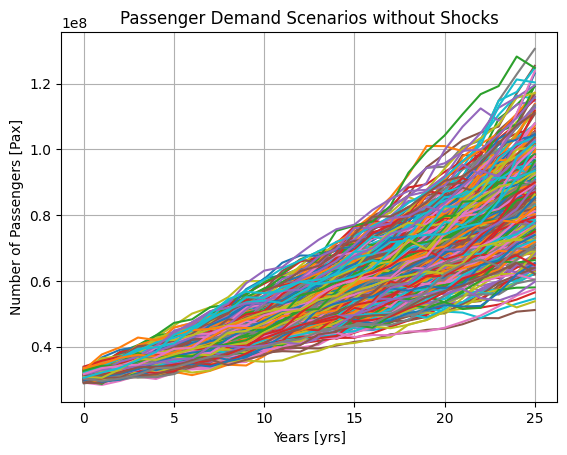

Plot saved to: c:\Users\Olivier Bieri\OneDrive - ZHAW\Master AV\Semester 3\Masterthesis\Plots\Run 22\Passenger_Demand_Scenarios_with_Shocks.pdf


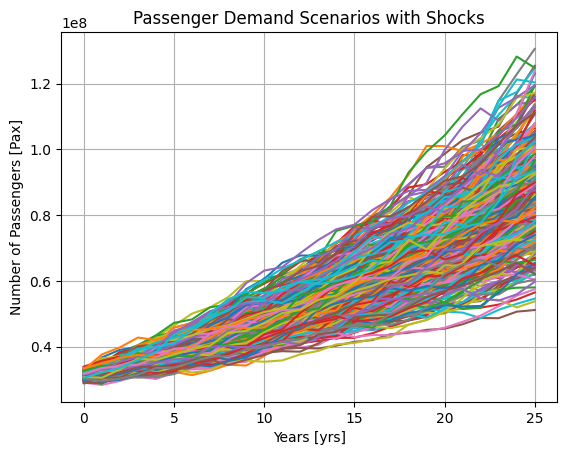

In [352]:
Forecast = fn.Generate_scenarios(Param)
fn.Scenario_plot(
    Param,
    Forecast,
    True,
    "Passenger Demand Scenarios without Shocks",
    "Number of Passengers [Pax]",
    True,
    run_name,
)

Shock_Scenarios = fn.Shock_generation(Param, Forecast, 10, False)
fn.Scenario_plot(
    Param,
    Shock_Scenarios,
    True,
    "Passenger Demand Scenarios with Shocks",
    "Number of Passengers [Pax]",
    True,
    run_name,
)

# # To see number of Shocks
# Shock_Scenarios = fn.Shock_generation(Param, Forecast, None, True)
# fn.Scenario_plot(Param, Shock_Scenarios[0], True, "Demand Scenarios with Shocks")
# print("Shocks generated", Shock_Scenarios[1])

## Design Hour Load

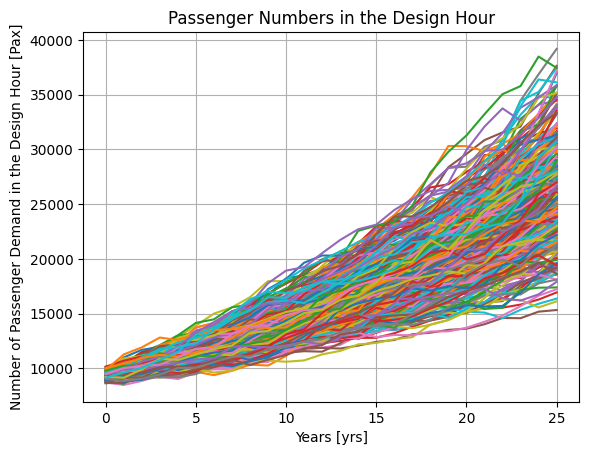

In [353]:
PAX_DHL = fn.DHL_Calculation(Param, Shock_Scenarios)
fn.Scenario_plot(
    Param,
    PAX_DHL,
    True,
    "Passenger Numbers in the Design Hour",
    "Number of Passenger Demand in the Design Hour [Pax]",
)

## Load Factor

Plot saved to: c:\Users\Olivier Bieri\OneDrive - ZHAW\Master AV\Semester 3\Masterthesis\Plots\Run 22\Load_Factor.pdf


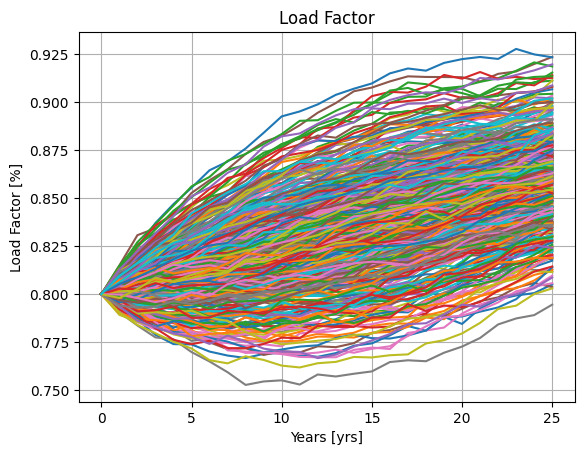

In [354]:
Load_Factor_matrix = fn.Load_Factor_matrix(Param, PAX_DHL)
fn.Scenario_plot(
    Param,
    Load_Factor_matrix,
    True,
    "Load Factor",
    "Load Factor [%]",
    True,
    run_name,
)

## Air Traffic Movements

In [355]:
d_ATM, d_ATM_mix = fn.ATM(Param, PAX_DHL, Load_Factor_matrix)

### Plotting the ATM

Plot saved to: c:\Users\Olivier Bieri\OneDrive - ZHAW\Master AV\Semester 3\Masterthesis\Plots\Run 22\Total_Air_Traffic_Movements_in_the_Design_Hour.pdf


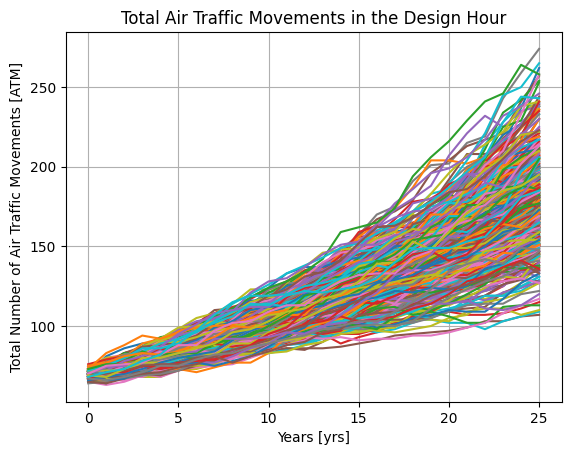

In [356]:
fn.Scenario_plot(
    Param,
    d_ATM,
    True,
    "Total Air Traffic Movements in the Design Hour",
    "Total Number of Air Traffic Movements [ATM]",
    True,
    run_name,
)


# fn.ATM_plot(d_ATM_mix, Param)

## S-Curve

S-Curve plot saved to: c:\Users\Olivier Bieri\OneDrive - ZHAW\Master AV\Semester 3\Masterthesis\Plots\Run 22\S_Curve_Plot.pdf


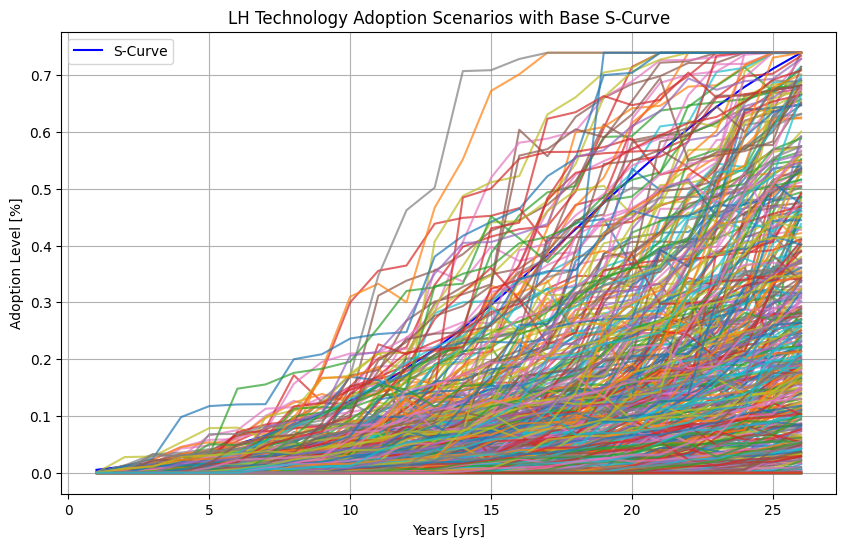

In [357]:
S_value_matrix = fn.S_curve(Param)
fn.S_curve_plot(Param, S_value_matrix, True, run_name)

# fn.Scenario_plot(
#     Param,
#     S_value_matrix,
#     NoStep=True,
#     Title="Technology Adoption without Standard S-Curve",
#     label="Percentage [%]",
# )

## Hydrogen Adoption

Plot saved to: c:\Users\Olivier Bieri\OneDrive - ZHAW\Master AV\Semester 3\Masterthesis\Plots\Run 22\LH_Air_Traffic_Movements_in_the_Design_Hour.pdf


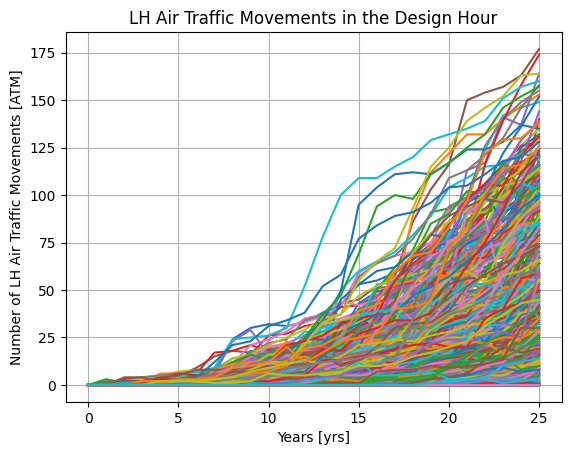

Plot saved to: c:\Users\Olivier Bieri\OneDrive - ZHAW\Master AV\Semester 3\Masterthesis\Plots\Run 22\Jet_Air_Traffic_Movements_in_the_Design_Hour.pdf


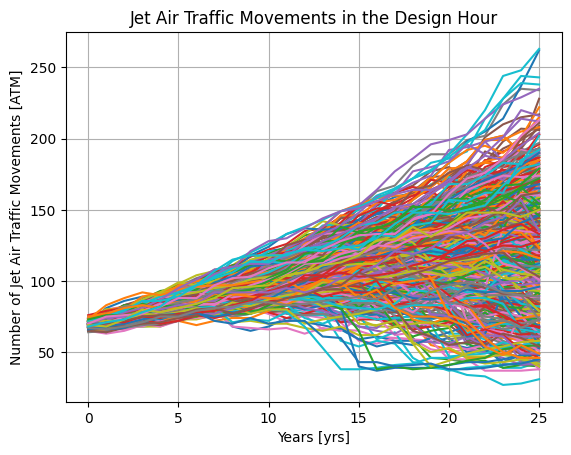

In [358]:
d_ATM_LH, d_ATM_LH_mix = fn.LH2_technology_adoption(Param, S_value_matrix, d_ATM_mix)

fn.Scenario_plot(
    Param,
    d_ATM_LH,
    True,
    "LH Air Traffic Movements in the Design Hour",
    "Number of LH Air Traffic Movements [ATM]",
    True,
    run_name,
)
# fn.ATM_plot(d_ATM_LH_mix, Param)

d_ATM_Jet = d_ATM - d_ATM_LH
fn.Scenario_plot(
    Param,
    d_ATM_Jet,
    True,
    "Jet Air Traffic Movements in the Design Hour",
    "Number of Jet Air Traffic Movements [ATM]",
    True,
    run_name,
)

d_ATM_Jet_mix = np.round(d_ATM_mix - d_ATM_LH_mix, 0)
# fn.ATM_plot(d_ATM_Jet_mix, Param)

# Completed Scenarios

In [359]:
# # Passenger Demand Scenario
# print("Pax: \t\t", Shock_Scenarios.shape)

# # Air Traffic Mix Scenario
# print("ATM Demand: \t", d_ATM.shape)
# print("ATM Mix Demand: ", d_ATM_mix.shape)

# # Technology Adoption Scenario
# print("S-Curve Values: ", S_value_matrix.shape)

## Yearly Stand Demand

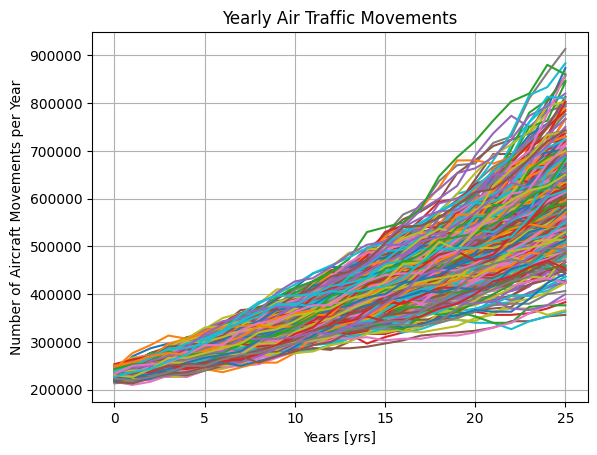

In [360]:
D_ATM, D_ATM_mix = fn.ATM_yearly(Param, d_ATM)

fn.Scenario_plot(
    Param,
    D_ATM,
    True,
    "Yearly Air Traffic Movements",
    "Number of Aircraft Movements per Year",
)

# fn.ATM_plot(D_ATM_mix, Param)

# Optimization Alorithm

In [361]:
delta_K_GA_dual = fn.GA_dual(Param, d_ATM_mix, S_value_matrix, Shock_Scenarios)
delta_K_GA_mix = delta_K_GA_dual[0] + delta_K_GA_dual[1]

# print(delta_K_GA_mix)

In [362]:
NPV_GA = fn.NPV_calculation(
    Param,
    delta_K_GA_dual[0],
    delta_K_GA_dual[1],
    d_ATM_mix,
    S_value_matrix,
    Shock_Scenarios,
)

## Visulization of Jet A1 Aircraft Stand Capacity

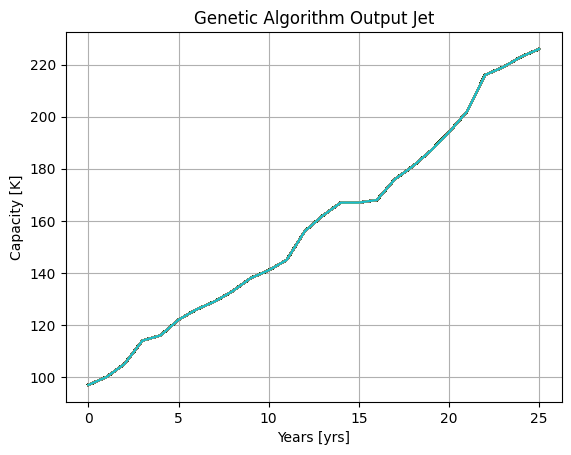

Plot saved to: c:\Users\Olivier Bieri\OneDrive - ZHAW\Master AV\Semester 3\Masterthesis\Plots\Run 22\Genetic_Algorithm_Output_for_Jet_with_ATM_Demand_Jet.pdf


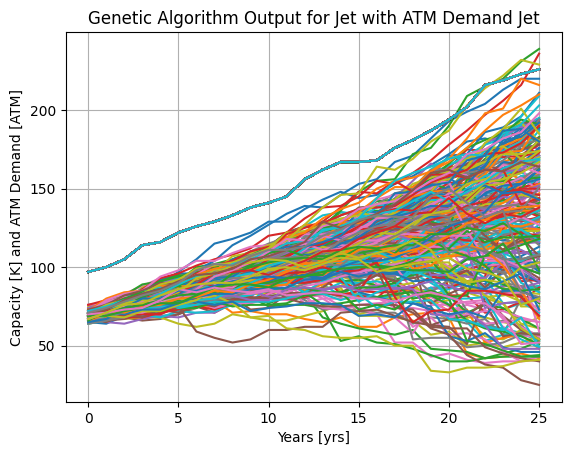

In [363]:
k_GA_Jet = fn.Capacity_2D(Param, delta_K_GA_dual[0])
fn.Scenario_plot(
    Param,
    k_GA_Jet,
    True,
    "Genetic Algorithm Output Jet",
    "Capacity [K]",
)
fn.Scenario_plot(
    Param,
    np.vstack((k_GA_Jet, d_ATM_Jet)),
    True,
    "Genetic Algorithm Output for Jet with ATM Demand Jet",
    "Capacity [K] and ATM Demand [ATM]",
    True,
    run_name,
)

## Visulization of LH2 Aircraft Stand Capacity

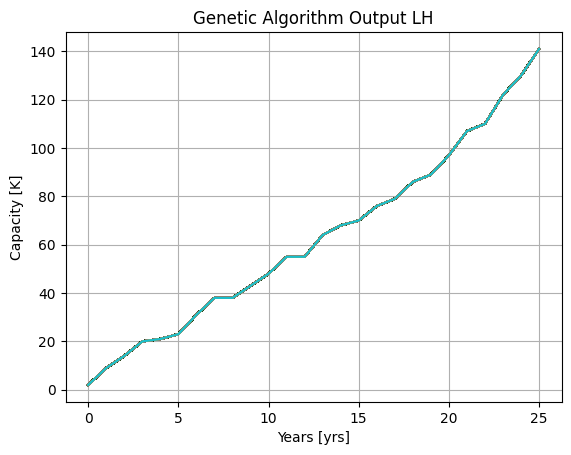

Plot saved to: c:\Users\Olivier Bieri\OneDrive - ZHAW\Master AV\Semester 3\Masterthesis\Plots\Run 22\Genetic_Algorithm_Output_for_LH_with_ATM_Demand_LH.pdf


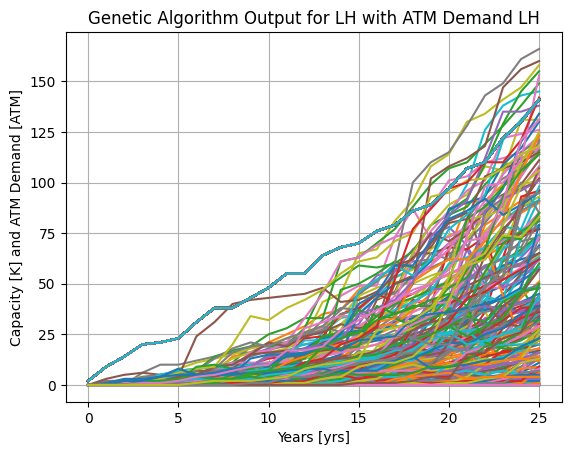

In [364]:
k_GA_LH = fn.Capacity_2D(Param, delta_K_GA_dual[1], True)
fn.Scenario_plot(Param, k_GA_LH, True, "Genetic Algorithm Output LH", "Capacity [K]")
fn.Scenario_plot(
    Param,
    np.vstack((k_GA_LH, d_ATM_LH)),
    True,
    "Genetic Algorithm Output for LH with ATM Demand LH",
    "Capacity [K] and ATM Demand [ATM]",
    True,
    run_name,
)

## Visulization of Total Aircraft Stand Capacity

Plot saved to: c:\Users\Olivier Bieri\OneDrive - ZHAW\Master AV\Semester 3\Masterthesis\Plots\Run 22\Total_Genetic_Algorithm_Output_with_ATM_Demand.pdf


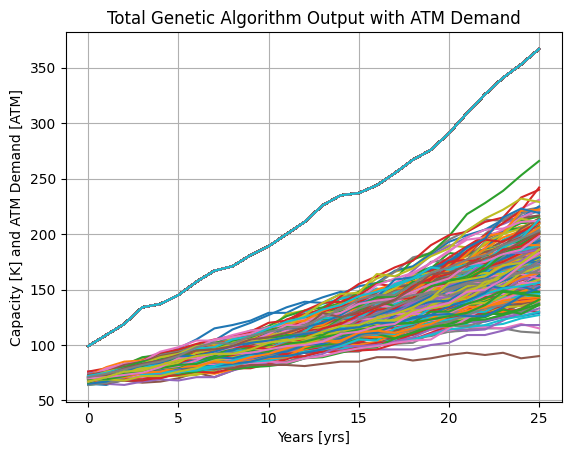

Plot saved to: c:\Users\Olivier Bieri\OneDrive - ZHAW\Master AV\Semester 3\Masterthesis\Plots\Run 22\Total_Genetic_Algorithm_Output_Mix_with_ATM_Demand_Mix.pdf


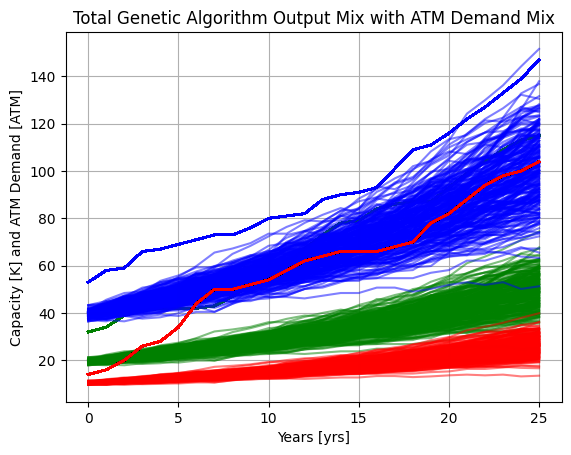

In [365]:
k_GA = fn.Capacity_2D(Param, delta_K_GA_mix)
k_GA_mix = fn.Capacity_3D(Param, delta_K_GA_mix, False)

fn.Scenario_plot(
    Param,
    np.vstack((k_GA, d_ATM)),
    True,
    "Total Genetic Algorithm Output with ATM Demand",
    "Capacity [K] and ATM Demand [ATM]",
    True,
    run_name,
)

fn.Scenario_plot(
    Param,
    np.vstack((k_GA_mix, d_ATM_mix)),
    True,
    "Total Genetic Algorithm Output Mix with ATM Demand Mix",
    "Capacity [K] and ATM Demand [ATM]",
    True,
    run_name,
)

In [366]:
K_GA_yearly, K_GA_yearly_mix = fn.K_yearly(Param, k_GA)

# Decision Rule

## Parameters for Decision Rule Optimization

In [367]:
Param["lower_theta"] = 0
Param["upper_theta"] = 20
Param["stepsize_theta"] = 2
Param["lower_condition"] = 2
Param["upper_condition"] = 8
Param["stepsize_condition"] = 2

## Parameter Evaluation

In [368]:
# Parameter_Evaluation
ENPV_Decision, Parameter_Decision = fn.Parameter_Evaluation(
    Param,
    d_ATM_Jet_mix,
    d_ATM_LH_mix,
    d_ATM_mix,
    S_value_matrix,
    Shock_Scenarios,
    Param["Parameter_sample_size"],
    True,
)
print("Maximum ENPV:", ENPV_Decision)
print("Best Parameters:", Parameter_Decision)

Maximum ENPV: 433718457.35577697
Best Parameters: (8, 18, 0, 2, 8, 8, 4, 2)


# Visualization of the Decision Rule

## Visulization of Jet A1 Aircraft Stand Capacity

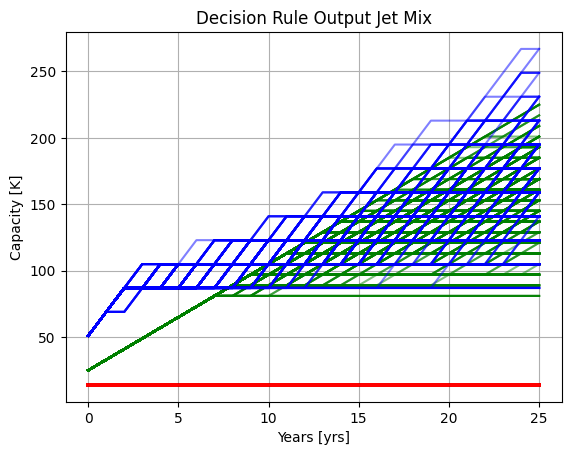

Plot saved to: c:\Users\Olivier Bieri\OneDrive - ZHAW\Master AV\Semester 3\Masterthesis\Plots\Run 22\Decision_Rule_Output_Jet_Mix_with_ATM_Demand_Jet_Mix.pdf


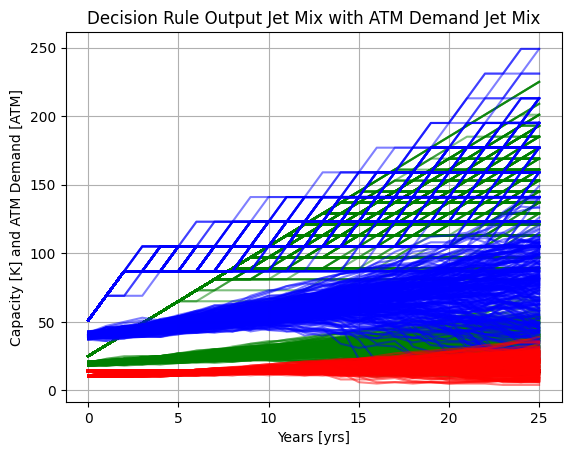

In [369]:
delta_K_Jet_Decision_short = fn.Decision_Rule(
    Param,
    Param["K0"] * Param["Mix"][0],
    d_ATM_Jet,
    Parameter_Decision[0],
    Parameter_Decision[3],
)
delta_K_Jet_Decision_medium = fn.Decision_Rule(
    Param,
    Param["K0"] * Param["Mix"][1],
    d_ATM_Jet,
    Parameter_Decision[1],
    Parameter_Decision[3],
)
delta_K_Jet_Decision_long = fn.Decision_Rule(
    Param,
    Param["K0"] * Param["Mix"][2],
    d_ATM_Jet,
    Parameter_Decision[2],
    Parameter_Decision[3],
)
delta_K_Jet_Decision_mix = np.stack(
    [
        delta_K_Jet_Decision_short,
        delta_K_Jet_Decision_medium,
        delta_K_Jet_Decision_long,
    ],
    axis=2,
)


k_Jet_Decision_mix = fn.Capacity_3D(Param, delta_K_Jet_Decision_mix, False)


fn.Scenario_plot(
    Param,
    k_Jet_Decision_mix,
    True,
    "Decision Rule Output Jet Mix",
    "Capacity [K]",
)

fn.Scenario_plot(
    Param,
    np.vstack((d_ATM_Jet_mix, k_Jet_Decision_mix)),
    True,
    "Decision Rule Output Jet Mix with ATM Demand Jet Mix",
    "Capacity [K] and ATM Demand [ATM]",
    True,
    run_name,
)

## Visulization of LH2 Aircraft Stand Capacity

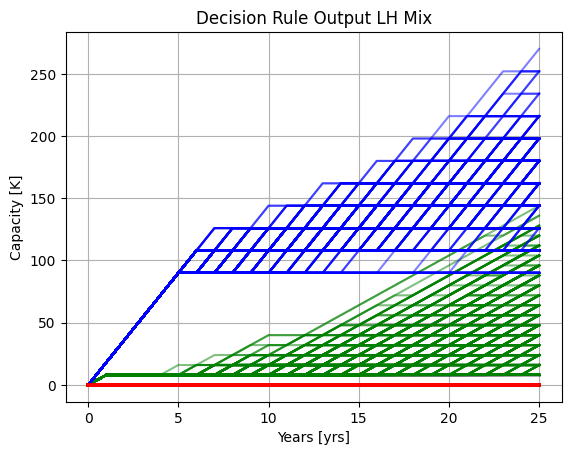

Plot saved to: c:\Users\Olivier Bieri\OneDrive - ZHAW\Master AV\Semester 3\Masterthesis\Plots\Run 22\Decision_Rule_Output_LH_Mix_with_ATM_Demand_LH_Mix.pdf


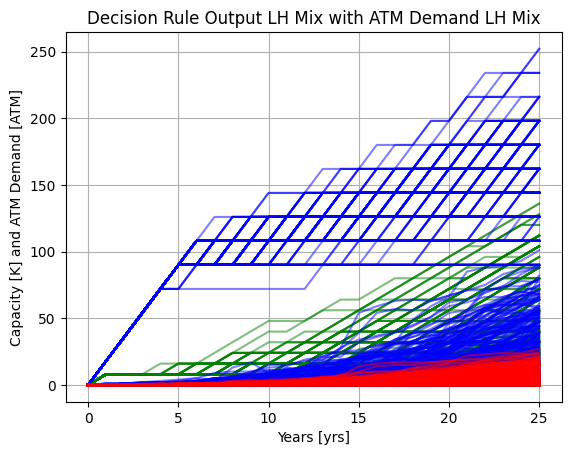

In [370]:
delta_K_LH_Decision_short = fn.Decision_Rule(
    Param,
    Param["K0_LH"] * Param["Mix"][0],
    d_ATM_LH,
    Parameter_Decision[0],
    Parameter_Decision[3],
)
delta_K_LH_Decision_medium = fn.Decision_Rule(
    Param,
    Param["K0_LH"] * Param["Mix"][1],
    d_ATM_Jet,
    Parameter_Decision[1],
    Parameter_Decision[3],
)
delta_K_LH_Decision_long = fn.Decision_Rule(
    Param,
    Param["K0_LH"] * Param["Mix"][2],
    d_ATM_Jet,
    Parameter_Decision[2],
    Parameter_Decision[3],
)
delta_K_LH_Decision_mix = np.stack(
    [
        delta_K_LH_Decision_short,
        delta_K_LH_Decision_medium,
        delta_K_LH_Decision_long,
    ],
    axis=2,
)


k_LH_Decision_mix = fn.Capacity_3D(Param, delta_K_LH_Decision_mix, True)
fn.Scenario_plot(
    Param,
    k_LH_Decision_mix,
    True,
    "Decision Rule Output LH Mix",
    "Capacity [K]",
)
fn.Scenario_plot(
    Param,
    np.vstack((d_ATM_LH_mix, k_LH_Decision_mix)),
    True,
    "Decision Rule Output LH Mix with ATM Demand LH Mix",
    "Capacity [K] and ATM Demand [ATM]",
    True,
    run_name,
)

## Visulization of the Combined Jet Aircraft Stand Capacity

### Decision Rule -> Optimize delta K for Mix (Short, Medium, Longhaul) and combine again for general Result

Plot saved to: c:\Users\Olivier Bieri\OneDrive - ZHAW\Master AV\Semester 3\Masterthesis\Plots\Run 22\Decision_Rule_Output_Jet.pdf


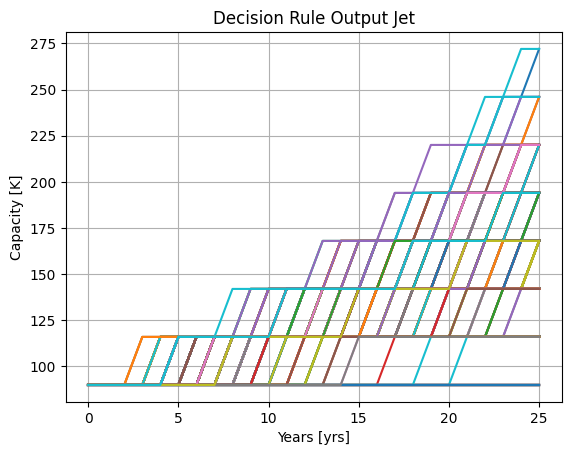

Plot saved to: c:\Users\Olivier Bieri\OneDrive - ZHAW\Master AV\Semester 3\Masterthesis\Plots\Run 22\Decision_Rule_Output_Jet_with_ATM_Demand_Jet.pdf


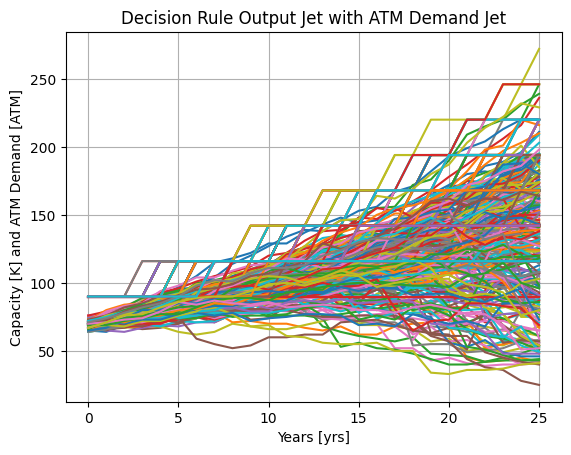

In [371]:
cond_Jet_Decision = Parameter_Decision[3]
theta_Jet_Decision = (
    Parameter_Decision[0] + Parameter_Decision[1] + Parameter_Decision[2]
)


delta_K_Jet_Decision = fn.Decision_Rule(
    Param, Param["K0"], d_ATM_Jet, theta_Jet_Decision, cond_Jet_Decision
)
k_Jet_Decision = fn.Capacity_2D(Param, delta_K_Jet_Decision)
fn.Scenario_plot(
    Param,
    k_Jet_Decision,
    True,
    "Decision Rule Output Jet",
    "Capacity [K]",
    True,
    run_name,
)
fn.Scenario_plot(
    Param,
    np.vstack((k_Jet_Decision, d_ATM_Jet)),
    True,
    "Decision Rule Output Jet with ATM Demand Jet",
    "Capacity [K] and ATM Demand [ATM]",
    True,
    run_name,
)

## Visulization of the Combined LH Aircraft Stand Capacity

Plot saved to: c:\Users\Olivier Bieri\OneDrive - ZHAW\Master AV\Semester 3\Masterthesis\Plots\Run 22\Decision_Rule_Output_LH.pdf


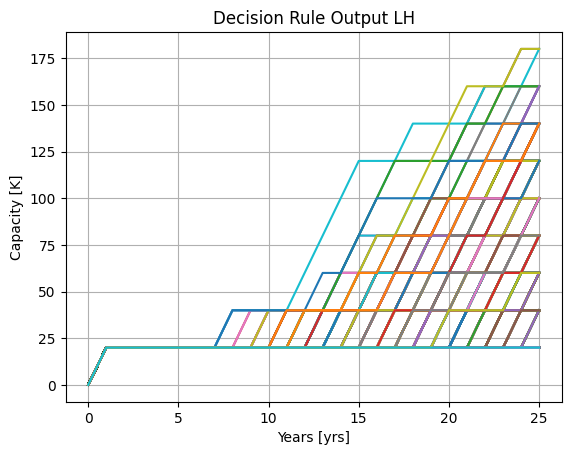

Plot saved to: c:\Users\Olivier Bieri\OneDrive - ZHAW\Master AV\Semester 3\Masterthesis\Plots\Run 22\Decision_Rule_Output_LH_with_ATM_Demand_LH.pdf


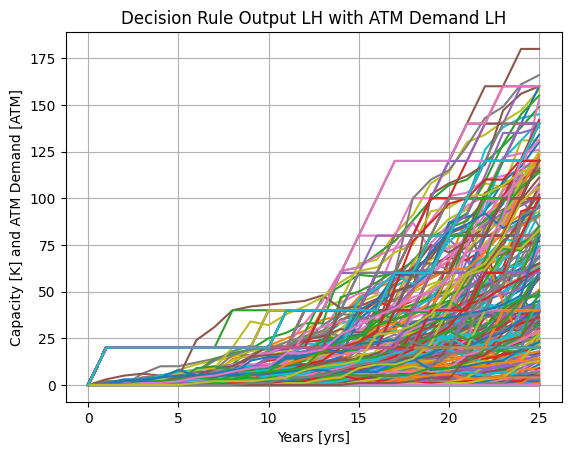

In [372]:
cond_LH_Decision = Parameter_Decision[7]
theta_LH_Decision = (
    Parameter_Decision[4] + Parameter_Decision[5] + Parameter_Decision[6]
)

delta_K_LH_Decision = fn.Decision_Rule(
    Param, Param["K0_LH"], d_ATM_LH, theta_LH_Decision, cond_LH_Decision
)
k_LH_Decision = fn.Capacity_2D(Param, delta_K_LH_Decision, True)
fn.Scenario_plot(
    Param,
    k_LH_Decision,
    True,
    "Decision Rule Output LH",
    "Capacity [K]",
    True,
    run_name,
)
fn.Scenario_plot(
    Param,
    np.vstack((k_LH_Decision, d_ATM_LH)),
    True,
    "Decision Rule Output LH with ATM Demand LH",
    "Capacity [K] and ATM Demand [ATM]",
    True,
    run_name,
)

## Visulization of the Total Aircraft Stand Capacity

Plot saved to: c:\Users\Olivier Bieri\OneDrive - ZHAW\Master AV\Semester 3\Masterthesis\Plots\Run 22\Total_Decision_Rule_Output_with_ATM_Demand.pdf


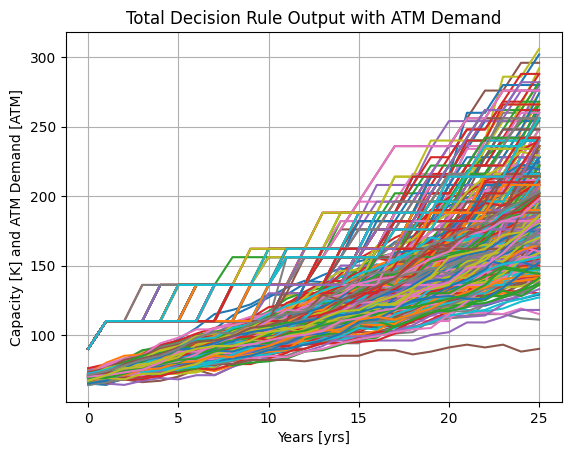

Plot saved to: c:\Users\Olivier Bieri\OneDrive - ZHAW\Master AV\Semester 3\Masterthesis\Plots\Run 22\Total_Decision_Rule_Output_Mix_with_ATM_Demand_Mix.pdf


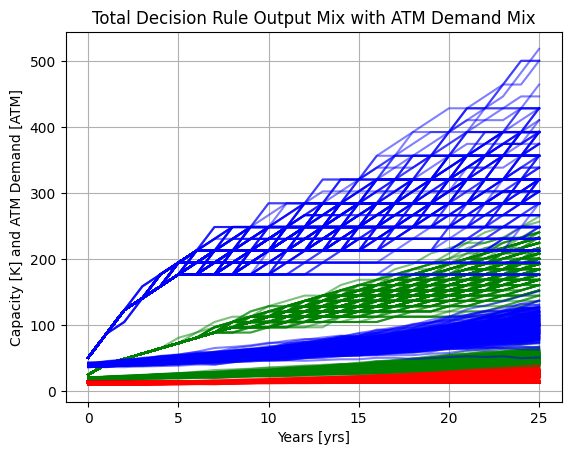

In [373]:
k_Decision = k_Jet_Decision + k_LH_Decision
k_Decision_mix = k_Jet_Decision_mix + k_LH_Decision_mix

fn.Scenario_plot(
    Param,
    np.vstack((k_Decision, d_ATM)),
    True,
    "Total Decision Rule Output with ATM Demand",
    "Capacity [K] and ATM Demand [ATM]",
    True,
    run_name,
)

fn.Scenario_plot(
    Param,
    np.vstack((k_Decision_mix, d_ATM_mix)),
    True,
    "Total Decision Rule Output Mix with ATM Demand Mix",
    "Capacity [K] and ATM Demand [ATM]",
    True,
    run_name,
)

# NPV Calculation

In [374]:
NPV_Decision = fn.NPV_calculation(
    Param,
    delta_K_Jet_Decision,
    delta_K_LH_Decision,
    d_ATM_mix,
    S_value_matrix,
    Shock_Scenarios,
)

# print(np.mean(NPV_Decision))

# CDF Plot

CDF plot saved to: c:\Users\Olivier Bieri\OneDrive - ZHAW\Master AV\Semester 3\Masterthesis\Plots\Run 22\CDF_Plot.pdf


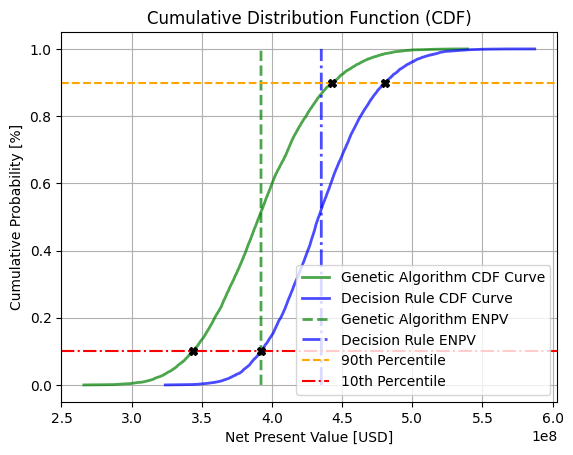

10th Percentile Genetic Algorithm: 343402278.2992929
90th Percentile Genetic Algorithm: 443115201.6806751
10th Percentile Decision Rule: 392045619.17525506
90th Percentile Decision Rule: 480606623.60531753
Genetic Algorithm: 392192632.94103277
Decision Rule: 435165514.5028004
ENPV_GA: 		 392192632.94103277
ENPV_Decision Rule: 	 435165514.5028004


In [375]:
fn.CDF_Plot(
    NPV_GA,
    NPV_Decision,
    "Genetic Algorithm",
    "Decision Rule",
    True,
    run_name,
)
print("ENPV_GA: \t\t", np.mean(NPV_GA))
print("ENPV_Decision Rule: \t", np.mean(NPV_Decision))

# Stopping the Runtime

In [376]:
end_time = time.time()

# Calculate the Total Runtime
total_run_time = end_time - start_time

# Display the Total Runtime
print("Total Runtime \t=", round(total_run_time, 2), "s")
print("Total Runtime \t=", round(total_run_time / 60, 2), "min")
print("Total Runs \t=", Param["No_Forecasts"])

Total Runtime 	= 2128.07 s
Total Runtime 	= 35.47 min
Total Runs 	= 10000


I adjusted the second smoothing (smoothing of Load Factor). Currently it is out commented in the Function as it safes 1/3 of the time. For "No_Forecasts": 30000 the Code takes 20 instead of 30 seconds.

# Multiprocessing

In [377]:
# import multiprocessing


# input_list = [Param.copy() for _ in range(Param["No_Forecasts"])]

# # Create a pool of worker processes
# with multiprocessing.Pool(processes=8) as pool:
#     results = pool.map(fn.ATM, input_list)  # Map function to pool

In [378]:
# from multiprocessing import Pool

# # input_list = list of each scenario (rows of Shock_forecast)
# input_list = [row for row in Shock_Scenarios]  # shape: [No_Forecasts, Fth]
# args_list = [(Param, scenario) for scenario in input_list]

# with Pool(processes=8) as pool:
#     results = pool.starmap(fn.Load_Factor_matrix, args_list)

In [379]:
# import multiprocessing as mp


# # Helper function for multiprocessing
# def compute_load_factor(scenario):
#     return fn.Load_Factor_matrix(Param, scenario)


# if __name__ == "__main__":
#     # Number of processes (or use mp.cpu_count())
#     pool = mp.Pool(processes=4)

#     # Map each scenario to the worker pool
#     results = pool.map(compute_load_factor, Shock_Scenarios)

#     pool.close()
#     pool.join()

#     # Combine results if needed (e.g., into a matrix)
#     LF_test_matrix = np.array(results)  # Or pd.DataFrame(results), etc.

## Loading Bar

In [380]:
# from tqdm.auto import tqdm

### Example Usage

In [381]:
# # Generate input list with separate dictionary copies
# input_list = [Param.copy() for _ in range(Param["No_Forecasts"])]

# # Create a pool of worker processes
# with multiprocessing.Pool(processes=8) as pool:
#     # Use imap_unordered for better progress tracking with tqdm
#     results = list(
#         tqdm(
#             pool.imap_unordered(fn.ATM, input_list),
#             total=len(input_list),
#             desc="Processing Forecasts",
#         )
#     )

# Saving the Data in a Pickle File

## Saving the Data

In [382]:
No_Forecasts = Param["No_Forecasts"]

# Timestamp
timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

# File name
filename = "MT_Experiment_Data.pkl"

# Load existing data if file exists, else start a new list
if os.path.exists(filename):
    with open(filename, "rb") as f:
        data = pickle.load(f)
else:
    data = []

# Construct new record
record = {
    "Run_Name": run_name,
    "Timestamp": timestamp,
    "Total_Runtime": total_run_time,
    "No_Forecasts": No_Forecasts,
    "Param": Param,
    "d_ATM": d_ATM,
    "d_ATM_mix": d_ATM_mix,
    "D_ATM": D_ATM,
    "D_ATM_mix": D_ATM_mix,
    "S_Values": S_value_matrix,
    "Shock_Scenarios": Shock_Scenarios,
    "Load_Factor_matrix": Load_Factor_matrix,
    "PAX_DHL": PAX_DHL,
    "delta_K_GA_dual": delta_K_GA_dual,  # Tuple of delta_K_Jet_mix and delta_K_LH_mix
    "delta_K_GA_mix": delta_K_GA_mix,
    "k_GA": k_GA,
    "k_GA_mix": k_GA_mix,
    "K_GA_yearly": K_GA_yearly,
    "K_GA_yearly_mix": K_GA_yearly_mix,
    "NPV_GA": NPV_GA,
    "ENPV_GA": np.mean(NPV_GA),
    "delta_K_Jet_Decision": delta_K_Jet_Decision,
    "delta_K_Jet_Decision_mix": delta_K_Jet_Decision_mix,
    "delta_K_LH_Decision": delta_K_LH_Decision,
    "delta_K_LH_Decision_mix": delta_K_LH_Decision_mix,
    "k_Jet_Decision": k_Jet_Decision,
    "k_Jet_Decision_mix": k_Jet_Decision,
    "k_LH_Decision": k_LH_Decision,
    "k_LH_Decision_mix": k_LH_Decision,
    "Parameter_Decision": Parameter_Decision,
    "NPV_Decision": NPV_Decision,
    "ENPV_Decision": ENPV_Decision,
}

# Append current run
data.append(record)

# Save back to pickle file
with open(filename, "wb") as f:
    pickle.dump(data, f)

print(f"Run '{run_name}' saved to MT_Experiment_Data.pkl at {timestamp}")

Run 'Run 22' saved to MT_Experiment_Data.pkl at 2025-08-10 23:58:21


## Deleting Data

To delete a Test Run, uncomment this code and enter the name of the Run in the Box

In [383]:
# run_name_to_delete = input("Enter the name of the run to delete: ").strip()

# new_runs = [run for run in all_runs if run["Run_Name"] != run_name_to_delete]

# if len(new_runs) < len(all_runs):
#     with open(filename, "wb") as f:
#         pickle.dump(new_runs, f)
#     print(f"Deleted all runs named '{run_name_to_delete}'")
# else:
#     print("No runs found with that name.")

## Visualizing Data

In [384]:
# Load the pickle file
with open("MT_Experiment_Data.pkl", "rb") as f:
    all_runs = pickle.load(f)

# Print summary of all runs
print(f"\nTotal runs stored: {len(all_runs)}\n")

for i, run in enumerate(all_runs):
    print(f"=== Run {i + 1} ===")
    print("Run Name: \t\t", run["Run_Name"])
    print("No_Forecasts:\t\t", run["No_Forecasts"])
    print(
        "Total Runtime:\t\t",
        round(run["Total_Runtime"], 2),
        "s",
        "\t",
        round(run["Total_Runtime"] / 60, 2),
        "min",
    )
    print("Timestamp:\t\t", run["Timestamp"])
    print(
        "mu, sigma, L, k, t0:\t",
        run["Param"]["mu"],
        run["Param"]["sigma"],
        run["Param"]["L"],
        run["Param"]["k"],
        run["Param"]["t0_factor"],
    )
    print("Keys:\t\t\t", list(run.keys()))
    print("ENPV_GA:\t\t", run["ENPV_GA"])
    print("ENPV_Decision:\t\t", run["ENPV_Decision"])
    print("Decision Rule Params:\t", run["Parameter_Decision"])
    print("Parameters: \t\t", run["Param"])


Total runs stored: 22

=== Run 1 ===
Run Name: 		 Run 1
No_Forecasts:		 10000
Total Runtime:		 1971.31 s 	 32.86 min
Timestamp:		 2025-08-09 15:46:59
mu, sigma, L, k, t0:	 0.02 0.03 0.4 0.2 0.3
Keys:			 ['Run_Name', 'Timestamp', 'Total_Runtime', 'No_Forecasts', 'Param', 'd_ATM', 'd_ATM_mix', 'D_ATM', 'D_ATM_mix', 'S_Values', 'Shock_Scenarios', 'Load_Factor_matrix', 'PAX_DHL', 'delta_K_GA_dual', 'delta_K_GA_mix', 'k_GA', 'k_GA_mix', 'K_GA_yearly', 'K_GA_yearly_mix', 'NPV_GA', 'ENPV_GA', 'delta_K_Jet_Decision', 'delta_K_Jet_Decision_mix', 'delta_K_LH_Decision', 'delta_K_LH_Decision_mix', 'k_Jet_Decision', 'k_Jet_Decision_mix', 'k_LH_Decision', 'k_LH_Decision_mix', 'Parameter_Decision', 'NPV_Decision', 'ENPV_Decision']
ENPV_GA:		 287766441.0695897
ENPV_Decision:		 345322381.57247585
Decision Rule Params:	 (10, 2, 0, 2, 0, 12, 2, 4)
Parameters: 		 {'seed': 1, 'Dt0': 30000000, 'dt': 1, 'Fth': 25, 'No_Forecasts': 10000, 'No_Forecasts_plot': 500, 'lambda': 0.004, 'shock_scale': 1.5, 'shock_d

## Plotting the saved data

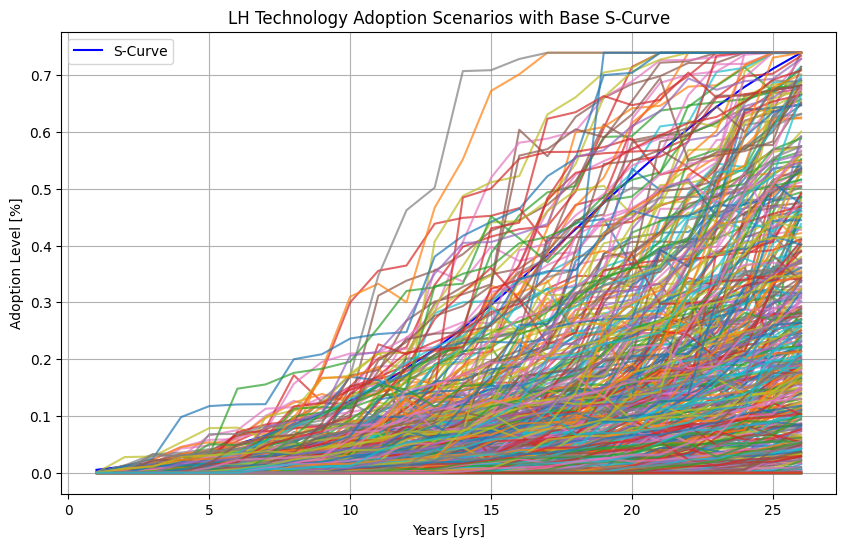

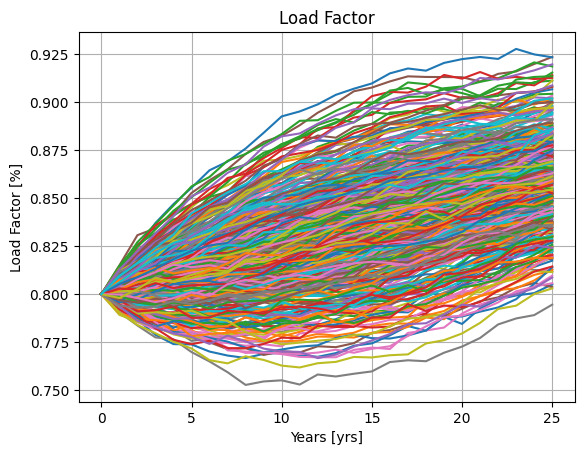

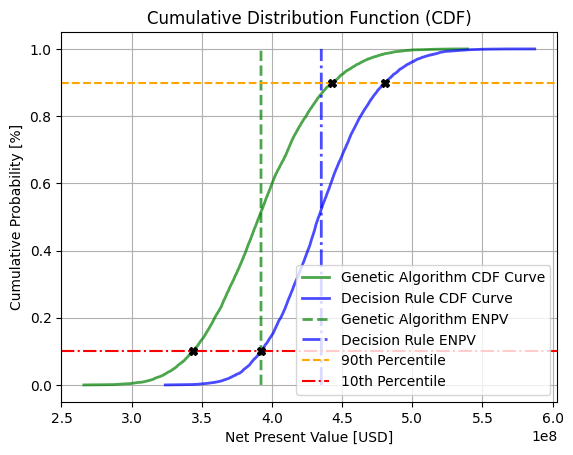

10th Percentile Genetic Algorithm: 343402278.2992929
90th Percentile Genetic Algorithm: 443115201.6806751
10th Percentile Decision Rule: 392045619.17525506
90th Percentile Decision Rule: 480606623.60531753
Genetic Algorithm: 392192632.94103277
Decision Rule: 435165514.5028004


In [385]:
Run = -1

fn.S_curve_plot(
    all_runs[Run]["Param"],
    all_runs[Run]["S_Values"],
)

fn.Scenario_plot(
    all_runs[Run]["Param"],
    all_runs[Run]["Load_Factor_matrix"],
    True,
    "Load Factor",
    "Load Factor [%]",
)

fn.CDF_Plot(
    all_runs[Run]["NPV_GA"],
    all_runs[Run]["NPV_Decision"],
    "Genetic Algorithm",
    "Decision Rule",
)

# Calculation of the Main Effects

In [386]:
# import pickle
# import re
# import matplotlib.pyplot as plt

# # Load the pickle file
# with open("MT_Test_Data.pkl", "rb") as f:
#     all_runs = pickle.load(f)

# # Regex pattern for "Test Run XX" (XX is integer, no decimal point)
# # pattern = r"^Test Run \d+$"
# pattern = r"^Test Run \d+$"  # Adjust this pattern as needed

# filtered_runs = [run for run in all_runs if re.match(pattern, run["Run_Name"])]

# run_names = [run["Run_Name"] for run in filtered_runs]
# enpv_ga = [run["ENPV_GA"] for run in filtered_runs]
# enpv_decision = [run["ENPV_Decision"] for run in filtered_runs]

# plt.figure(figsize=(12, 6))
# plt.plot(run_names, enpv_ga, marker="o", label="ENPV Genetic Algorithm")
# plt.plot(run_names, enpv_decision, marker="s", label="ENPV Decision Rule")

# plt.xticks(rotation=45, ha="right")
# plt.xlabel("Run Name")
# plt.ylabel("ENPV Value")
# plt.title("ENPV Values for Test Runs")
# plt.legend()
# plt.tight_layout()
# plt.grid()
# plt.show()

In [387]:
# import pickle
# import pandas as pd
# import re

# # Load the pickle file
# with open("MT_Test_Data.pkl", "rb") as f:
#     all_runs = pickle.load(f)

# # Regex to match "Test Run XX" (XX is integer, no decimal)
# pattern = r"^Test Run \d+$"

# rows = []
# for run in all_runs:
#     if re.match(pattern, run["Run_Name"]):
#         row = {
#             "Run_Name": run["Run_Name"],
#             "mu": run["Param"]["mu"],
#             "sigma": run["Param"]["sigma"],
#             "L": run["Param"]["L"],
#             "k": run["Param"]["k"],
#             "T0": run["Param"]["t0_factor"],  # Rename for clarity
#             "ENPV_GA": run["ENPV_GA"],
#             "ENPV_Decision": run["ENPV_Decision"],
#             "date": run.get("Timestamp", None),
#         }
#         rows.append(row)

# # Create DataFrame
# df = pd.DataFrame(rows)

# # Verify 32 runs
# if len(df) != 32:
#     raise ValueError(f"Expected 32 runs, got {len(df)}.")

# # Ensure factor levels are coded as -1/+1
# for col in ["mu", "sigma", "L", "k", "T0"]:
#     vals = sorted(df[col].unique())
#     # If not coded as -1/+1, map lowest to -1, highest to +1
#     if set(vals) != {-1, 1}:
#         df[col] = df[col].map({vals[0]: -1, vals[-1]: 1})

# factors = ["mu", "sigma", "L", "k", "T0"]
# effects_ga = {}
# effects_decision = {}

# for factor in factors:
#     mean_low_ga = df[df[factor] == -1]["ENPV_GA"].mean()
#     mean_high_ga = df[df[factor] == 1]["ENPV_GA"].mean()
#     effects_ga[factor] = mean_high_ga - mean_low_ga

#     mean_low_decision = df[df[factor] == -1]["ENPV_Decision"].mean()
#     mean_high_decision = df[df[factor] == 1]["ENPV_Decision"].mean()
#     effects_decision[factor] = mean_high_decision - mean_low_decision

# print("Main Effects (ENPV_GA):")
# for factor, effect in effects_ga.items():
#     print(f"{factor}: {effect:.3f}")

# print("\nMain Effects (ENPV_Decision):")
# for factor, effect in effects_decision.items():
#     print(f"{factor}: {effect:.3f}")

# # Optional: summary table
# summary = pd.DataFrame(
#     {
#         "Main Effect ENPV_GA": pd.Series(effects_ga),
#         "Main Effect ENPV_Decision": pd.Series(effects_decision),
#     }
# )
# print("\nSummary Table of Main Effects:")
# print(summary)